## Import required packages

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Create Dataframes for each dataset

In [2]:
ta_df = pd.read_csv('../../data/bitcoin-all-technical-indicators.csv') 
ta_df['timestamp'] = pd.to_datetime(ta_df['timestamp'])
oc_df = pd.read_csv('../../data/bitcoin-all-on-chain.csv')
oc_df['timestamp'] = pd.to_datetime(oc_df['timestamp'])
oc_ta_df = pd.read_csv('../../data/bitcoin-all-on-chain-and-technical-indicators.csv')
oc_ta_df['timestamp'] = pd.to_datetime(oc_ta_df['timestamp'])


## Visualisation function

In [3]:
def plot_values(timestamp, *args):
    import matplotlib

    if len(args) % 2 != 0:
        raise ValueError("Every feature should have a corresponding name")

    # Use a predefined style
    plt.style.use('ggplot')

    # Set figure size
    fig, ax = plt.subplots(figsize=(12,6))

    # Create a colormap that will generate colors
    colormap = matplotlib.colormaps['tab10']

    # Plot data with customized line for each feature
    for i in range(0, len(args), 2):
        feature_name = args[i]
        feature_values = args[i+1]
        color = colormap(i // 2 / (len(args)//2))
        ax.plot(timestamp, feature_values, label=feature_name, color=color, linewidth=1)

    # Set labels with improved readability
    ax.set_xlabel('Date')
    ax.yaxis.set_label_position("right") # This line moves y label to the right
    ax.set_ylabel('Feature Values')
    ax.yaxis.tick_right() # This line moves y axis to the right
    ax.set_title('Features over Time')

    # Format the timestamps and set locator
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format as year-month-day
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # display a label at the start of every 3rd month

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add a grid
    ax.grid(True)

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

#Usage:    
#plot_values(ta_df['timestamp'], 'price', ta_df['price'], 'price+500', ta_df['price']+500)

## Data Preperation Function

In [29]:
def data_preperation(df, lookback, future, scale, test_size=0.1):
    # Convert 'Date' column to datetime
    date_train = pd.to_datetime(df['timestamp'])
    df = df.drop(columns=['timestamp'])

    # Ensure all data is float type
    df = df.astype(float)

    # Split data into training and testing before scaling
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

    # Scale data
    df_train_scaled = scale.fit_transform(df_train)
    df_test_scaled = scale.transform(df_test)  # use the scaler fitted on the training data

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(df_train_scaled)-future+1):
        X_train.append(df_train_scaled[i-lookback:i, :])
        y_train.append(df_train_scaled[i+future-1:i+future, 0])

    X_test, y_test = [], []
    for i in range(lookback, len(df_test_scaled)-future+1):
        X_test.append(df_test_scaled[i-lookback:i, :])
        y_test.append(df_test_scaled[i+future-1:i+future, 0])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test, date_train

#Usage: 
#scale = MinMaxScaler(feature_range=(0,1))
#X_train, X_test, y_train, y_test, date_train = data_preperation(ta_df, 30, 1, scale)


In [5]:
def model_checkpoint(model_name, save_path="model_checkpoints"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor="val_loss",
                                              verbose=0, 
                                              save_best_only=True)

In [53]:
## Model 1. Lstm

In [30]:
def lstm_1(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y, validation_split=0.2, epochs=10, batch_size=32, callbacks=[model_checkpoint(model_name=model.name)])
    return model

In [21]:
def lstm_2(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)
    
    
    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y,validation_split=0.2,epochs=100,batch_size=32,verbose=1, callbacks=[model_checkpoint(model_name=model.name)])
    return model

In [31]:
scale = MinMaxScaler(feature_range=(0,1))
X_train, X_test, y_train, y_test, date_train = data_preperation(ta_df, 60, 1, scale)
model=lstm_1(X_train, y_train)
predictions = model.predict(X_test)
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scale.min_[0], scale.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)
y_test = y_test.reshape(-1, 1)  # reshaping
y_test = price_scaler.inverse_transform(y_test)


# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# R-squared (R2)
r2 = r2_score(y_test, predictions)
print("R-squared (R2):", r2)

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.0688

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


65/65 [==============================] - 65s 914ms/step - loss: 0.0688 - val_loss: 0.0798
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 6.4099e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


65/65 [==============================] - 83s 1s/step - loss: 6.4099e-04 - val_loss: 0.0361
Epoch 3/10
65/65 [==============================] - 64s 991ms/step - loss: 4.4703e-04 - val_loss: 0.0364
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 3.6350e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


65/65 [==============================] - 82s 1s/step - loss: 3.6350e-04 - val_loss: 0.0353
Epoch 5/10
65/65 [==============================] - 64s 983ms/step - loss: 3.3265e-04 - val_loss: 0.0372
Epoch 6/10
65/65 [==============================] - 63s 965ms/step - loss: 2.8545e-04 - val_loss: 0.0358
Epoch 7/10
65/65 [==============================] - ETA: 0s - loss: 2.5040e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688137543\assets


65/65 [==============================] - 81s 1s/step - loss: 2.5040e-04 - val_loss: 0.0286
Epoch 8/10
65/65 [==============================] - 62s 954ms/step - loss: 2.3306e-04 - val_loss: 0.0357
Epoch 9/10
65/65 [==============================] - 62s 952ms/step - loss: 2.3068e-04 - val_loss: 0.0345
Epoch 10/10
8/8 [==============================] - 3s 184ms/step
Mean Absolute Error (MAE): 1116.7176172992995
Mean Squared Error (MSE): 2554088.8146949224
Root Mean Squared Error (RMSE): 1598.15168701063
Mean Absolute Percentage Error (MAPE): 4.980838688965467
R-squared (R2): 0.8408468757263634


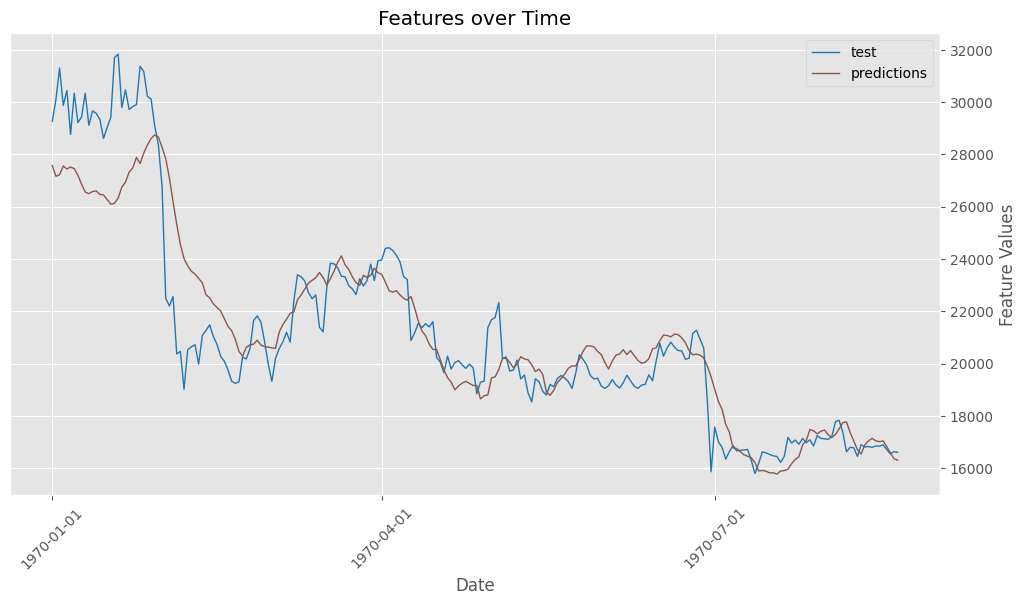

In [33]:
plot_values(range(232), 'test', y_test, 'predictions', predictions)